# 24.08.01 머신러닝 학습 17회차: 그래디언트 부스팅 알고리즘

## 01 개념

### 🔎부스팅(Boosting) 알고리즘: 상위 개념

1. 여러 약한 학습기를 결합하여 강한 학습기를 만드는 앙상블 방법이다.

2. 그래디언트 부스팅에서는 각 약한 학습기가 순차적으로 훈련되며, 각 학습기는 이전 학습기의 오류를 줄이도록 설계된다.

3. 부스팅의 대표적인 구현은 **에이다 부스트, 그래디언트 부스트**가 있다.

4. 에이다 부스트: 오류 데이터에 가중치를 부여하면서 부스팅을 수행한다. GBM과 가중치 업데이트 방식이 다르다.

### 💡GBM(Gradient Boosting Machine)

1. 앙상블 기법의 대표 알고리즘은 랜덤 포레스트, 그래디언트 부스팅이 있다.

2. 여러 약한 예측 모델(주로 결정 트리)을 결합하여 강력한 예측 모델을 만드는 알고리즘.

3. 각 단계에서 새로운 약한 학습기는 이전 단계의 모델이 만든 오차(**잔차**)를 보완하도록 훈련된다.

4. 회귀와 분류 문제 모두에 사용할 수 있으며, 매우 높은 예측 정확도를 제공한다.

### 🔎잔차(Residual)

1. 잔차는 예측 값과 실제 값의 차이이다.

2. 그래디언트 부스팅에서는 각 단계에서 잔차를 예측하도록 약한 학습기를 훈련한다.

3. 잔차를 줄이는 방향으로 새로운 모델이 추가된다. = 경사 하강법(Gradient Descent)

### 🔎Gradient Descent

1. 그래디언트 부스팅에서 "그래디언트"라는 용어는 손실 함수의 그래디언트를 따라 최적화가 이루어진다는 것을 의미한다.

2. 각 단계에서 잔차에 대해 손실 함수의 그래디언트를 계산하고, 이를 이용해 새로운 약한 학습기를 훈련시킨다.

### 💡GBM 동작 과정

1. 초기 모델 학습: 초기 모델 𝐹0(𝑥)를 학습한다. 회귀 문제의 경우, 보통 데이터의 평균 값을 사용한다.

2. 잔차 계산: 데이터의 실제 값과 초기 모델의 예측 값 사이의 잔차(오차)를 계산한다.

3. 새로운 약한 학습기 훈련: 잔차를 예측하는 새로운 약한 학습기 ℎ𝑚(𝑥)를 훈련시킨다. 이 약한 학습기는 이전 모델이 잘못 예측한 부분을 학습한다.

4. 모델 업데이트: 새로운 모델은 이전 모델에 학습된 약한 학습기를 추가하여 업데이트된다.

    - 수식: 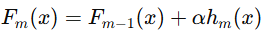

    - 여기서 𝛼는 학습률로, 각 단계에서 모델에 추가되는 기여 정도를 조절한다.

5. 반복: 위의 과정을 설정된 약한 학습기의 수만큼 반복한다.

### 💡GBM 장단점

1. 장점

    - 높은 예측 성능: 여러 약한 학습기를 결합하여 매우 높은 예측 성능을 제공한다.

    - 유연성: 손실 함수와 약한 학습기를 다양한 방법으로 설정할 수 있어 여러 문제에 적용 가능하다.

    - 해석력: 결정 트리를 사용하여 모델의 예측 과정을 쉽게 해석할 수 있다.

2. 단점

    - 훈련 시간: 많은 약한 학습기를 순차적으로 훈련해야 하므로 **훈련 시간**이 오래 걸릴 수 있다.

    - 과적합: 적절한 정규화와 조기 종료를 사용하지 않으면 과적합이 발생할 수 있다.

    - 복잡성: 하이퍼파라미터 조정 등 구현과 튜닝이 복잡할 수 있다.

### 🔎결론

1. 그래디언트 부스팅은 매우 강력하고 유연한 기법으로, 특히 대규모 데이터셋이나 복잡한 데이터 패턴을 다룰 때 매우 유용다다.

2. 그러나 적절한 튜닝과 검증이 필요하며, 과적합을 방지하기 위해 신중하게 사용해야 한다.

## 02 코드 실습: 사용자 행동 인식 데이터

In [1]:
# 머신러닝 라이브러리 불러오기
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 사용자 행동 인식 데이터 세트
feature_name_df = pd.read_csv('./dataset/human_activity/features.txt', sep='\s+',
                              header=None, names=['column_index', 'column_name'])

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x: x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset():
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()
    X_train = pd.read_csv('./dataset/human_activity/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('./dataset/human_activity/test/X_test.txt', sep='\s+', names=feature_name)
    y_train = pd.read_csv('./dataset/human_activity/train/y_train.txt', sep='\s+', names=['action'])
    y_test = pd.read_csv('./dataset/human_activity/test/y_test.txt', sep='\s+', names=['action'])
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [3]:
# GBM 수행 시간 측정을 위해서 시작 시간을 설정한다.
import time
start_time = time.time()

# 모델 학습 4단계 그대로
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print(f'GBM 정확도: {gb_accuracy:.4f}')
print(f'GBM 수행시간: {time.time()-start_time}')

GBM 정확도: 0.9393
GBM 수행시간: 638.1653544902802


### 🔎코드 실행 결과

1. 랜덤 포레스트 정확도: 0.9196, GBM 예측 정확도: 0.9389

2. But 약한 학습기의 순차적인 예측 오류 보정으로 인해 병렬처리가 지원되지 않음.

3. 정말이지 너무 오래 걸린다.

## 03 코드 실습(2): 대출 예측 프로젝트

### 불러오기

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import missingno as mso
import seaborn as sns
import warnings
import os
import scipy

from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [8]:
df = pd.read_csv("./dataset/train_u6lujuX_CVtuZ9i (1).csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### 데이터 전처리

In [9]:
df = df.drop(['Loan_ID'], axis = 1)

In [10]:
df['Gender'].fillna(df['Gender'].mode()[0],inplace=True)
df['Married'].fillna(df['Married'].mode()[0],inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0],inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0],inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0],inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0],inplace=True)

In [11]:
df['LoanAmount'].fillna(df['LoanAmount'].mean(),inplace=True)

In [12]:
df = pd.get_dummies(df)

# Drop columns
df = df.drop(['Gender_Female', 'Married_No', 'Education_Not Graduate', 
              'Self_Employed_No', 'Loan_Status_N'], axis = 1)

# Rename columns name
new = {'Gender_Male': 'Gender', 'Married_Yes': 'Married', 
       'Education_Graduate': 'Education', 'Self_Employed_Yes': 'Self_Employed',
       'Loan_Status_Y': 'Loan_Status'}
       
df.rename(columns=new, inplace=True)

In [22]:
# Q1 = df.quantile(0.25)
# Q3 = df.quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [14]:
df.ApplicantIncome = np.sqrt(df.ApplicantIncome)
df.CoapplicantIncome = np.sqrt(df.CoapplicantIncome)
df.LoanAmount = np.sqrt(df.LoanAmount)

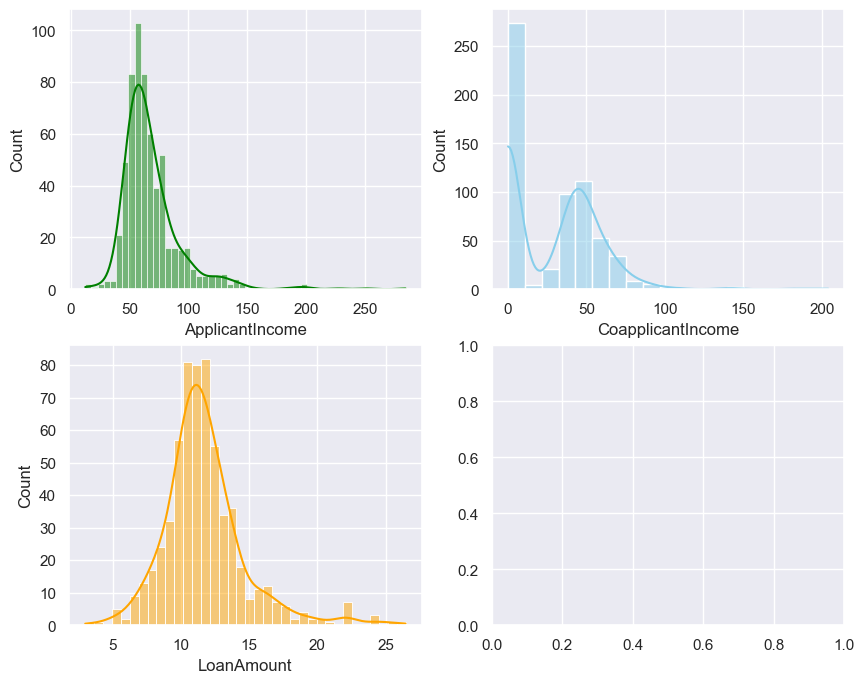

In [15]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(data=df, x="ApplicantIncome", kde=True, ax=axs[0, 0], color='green')
sns.histplot(data=df, x="CoapplicantIncome", kde=True, ax=axs[0, 1], color='skyblue')
sns.histplot(data=df, x="LoanAmount", kde=True, ax=axs[1, 0], color='orange');

In [16]:
X = df.drop(["Loan_Status"], axis=1)
y = df["Loan_Status"]

In [21]:
# X, y = SMOTE().fit_resample(X, y)

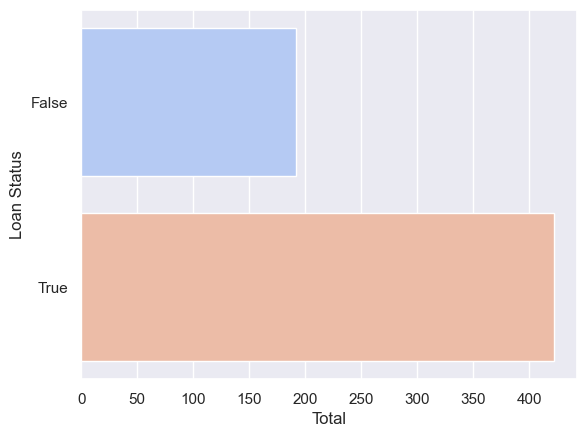

In [18]:
sns.set_theme(style="darkgrid")
sns.countplot(y=y, data=df, palette="coolwarm")
plt.ylabel('Loan Status')
plt.xlabel('Total')
plt.show()

In [19]:
X = MinMaxScaler().fit_transform(X)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Gradient Boosting 코드

In [26]:
paramsGB={'n_estimators':[100,200,300,400,500],
      'max_depth':[1,2,3,4,5],
      'subsample':[0.5,1],
      'max_leaf_nodes':[2,5,10,20,30,40,50]}

In [ ]:
# 시간이 오래 걸려서 pass but 다양한 분류기를 사용하는 프로젝트라 실습하기 좋음.
GB = RandomizedSearchCV(GradientBoostingClassifier(), paramsGB, cv=20)
GB.fit(X_train, y_train)

In [ ]:
GBclassifier = GradientBoostingClassifier(subsample=0.5, n_estimators=400, max_depth=4, max_leaf_nodes=10)
GBclassifier.fit(X_train, y_train)

y_pred = GBclassifier.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import accuracy_score
GBAcc = accuracy_score(y_pred,y_test)
print('Gradient Boosting accuracy: {:.2f}%'.format(GBAcc*100))

In [ ]:
print(GB.best_estimator_)
print(GB.best_score_)
print(GB.best_params_)
print(GB.best_index_)

## 04 참고 링크

https://www.kaggle.com/code/caesarmario/loan-prediction-w-various-ml-models/notebook